# NVIDIA AI Developer Day
## NVIDIA Inference Technology:<br> Deep-dive on TensorRT, Transfer Learning Toolkit and Deepstream
This notebook shows an example usecase of SSD object detection inference.<br>
[TensorRT (Session1)](#head-a) and [Transfer learning toolkit (Session2)](#head-b) will help you to optimize and quantize your network. <br>
And Deepstream will be great framework for your Real-time Intelligent Video Analysis application.




## [ Session 1. TensorRT ]<a class="anchor" id="head-a"></a>

In the Session 1, there is an usecase of TensorRT with a pre-trained TF-model ("ssd_inception_v2_coco_2017_11_17").<br>
This lecture includes contents as below and it follows a general [Tensorflow Workflow](#picture-1).

#### < TensorRT: Workflow > <a class="anchor" id="picture-1"></a>
![TensorRT workflow](images/tensorrt_workflow.png)
<br>

# TensorRT SSD example

1. [Prepare pre-trained model](#head-1) <br>
2. [Graph Surgeon](#head-2) <br>
    2.1 [Add Plugins](#head-2-1) <br>
    2.1.1 [(Optional)Custom Operation](#head-2-1-1) <br>
    2.2 [Graph Surgeon](#head-2-2) <br>
3. [Build TensorRT engine](#head-3) <br>
    3.1 [Build and serialize TRT engine](#head-3-1) <br>
    3.2 [Deserialize TRT engine](#head-3-2) <br>
4. [TensorRT inference](#head-4) <br>
    4.1 [Initialize performing inference](#head-4-1) <br>
    4.2 [Run inference](#head-4-2) <br>
    4.3 [Check Output](#head-4-3) <br>
5. [(Additional)TensorRT inference on Deepstream pipeline](#head-5) <br>

## 1. Prepare pre-trained model <a class="anchor" id="head-1"></a>
![TensorRT workflow1](images/tensorrt_workflow1.png)
- Download Pretrained Model from TF model zoo.
- Check model by using TensorBoard.

In [1]:
import os
import sys
from utils.paths import PATHS      # Path management
import utils.model as model_utils  # Download TF model

# Set Base-Paths
WORKSPACE_PATH = os.getcwd()
PATHS.set_workspace_dir_path(WORKSPACE_PATH)

MODEL_NAME     ="ssd_inception_v2_coco_2017_11_17"
MODEL_PATH     = PATHS.get_model_dir_path(MODEL_NAME)
MODEL_PB_PATH  = PATHS.get_model_pb_path(MODEL_NAME)
MODEL_UFF_PATH = PATHS.get_model_uff_path(MODEL_NAME)

# Model Input details
MODEL_INPUT_NAME  = "Input"
MODEL_INPUT_SHAPE = (3, 300, 300)
MODEL_OUTPUT_NAME = "NMS"

# Prepare SSD_inceptionv2 from tensorflow model zoo
if not os.path.exists(MODEL_PB_PATH):
    model_utils.download_model(MODEL_NAME)

In [2]:
from tensorflow.core.framework import graph_pb2
from tensorflow.python.client import session
from tensorflow.python.framework import importer
from tensorflow.python.framework import ops
from tensorflow.python.platform import app
from tensorflow.python.platform import gfile
from tensorflow.python.summary import summary

def import_to_tensorboard(model_dir, log_dir):
  """View an imported protobuf model (`.pb` file) as a graph in Tensorboard.
  Args:
    model_dir: The location of the protobuf (`pb`) model to visualize
    log_dir: The location for the Tensorboard log to begin visualization from.
  Usage:
    Call this function with your model location and desired log directory.
    Launch Tensorboard by pointing it to the log directory.
    View your imported `.pb` model as a graph.
  """
  with session.Session(graph=ops.Graph()) as sess:
    with gfile.GFile(model_dir, "rb") as f:
      graph_def = graph_pb2.GraphDef()
      graph_def.ParseFromString(f.read())
      importer.import_graph_def(graph_def)

    pb_visual_writer = summary.FileWriter(log_dir)
    pb_visual_writer.add_graph(sess.graph)
    print("Model Imported. Visualize by running: "
          "tensorboard --logdir={}".format(log_dir))

In [3]:
TENSORBOARD_DIR = WORKSPACE_PATH + "/models/" + MODEL_NAME + "/tnesorboard/"

import_to_tensorboard(MODEL_PB_PATH, TENSORBOARD_DIR)

Model Imported. Visualize by running: tensorboard --logdir=/workspace/ssd/models/ssd_inception_v2_coco_2017_11_17/tnesorboard/


In [5]:
!tensorboard --logdir=/workspace/ssd/models/ssd_inception_v2_coco_2017_11_17/tnesorboard/

TensorBoard 1.15.0 at http://bcde6d3111d2:6006/ (Press CTRL+C to quit)
W1022 06:27:25.700280 140006865348352 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
^C


![Pre-trained model on tensorboard](images/model.png)

## 2. Graph Surgeon <a class="anchor" id="head-2"></a>
![TensorRT workflow2](images/tensorrt_workflow2.png)

- Add pre-built or custom plugins by using [TensorRT Open Source Software(OSS)](https://github.com/NVIDIA/TensorRT).
- Map plugins to unsupported operator.
- Graph-surgery
<br>



### 2.1 Add Plugins <a class="anchor" id="head-2-1"></a>


If your network model has unsupported operator in TensorRT builder, Use pre-built plugins.<br>
There are many pre-built plugins for frequently-used operator in [TensorRT OSS Plugin set](https://github.com/NVIDIA/TensorRT/tree/master/plugin) as below.


|  TensorRT Pre-built Plugins  |
|:---------------:|
RPROI_TRT
Normalize_TRT
PriorBox_TRT
GridAnchor_TRT
NMS_TRT
BatchedNMS_TRT
LReLU_TRT
Reorg_TRT
Region_TRT
Clip_TRT
FlattenConcat_TRT
ResizeNearest_TRT
SpecialSlice_TRT
BatchTilePlugin_TRT
Proposal
ProposalLayer_TRT
PyramidROIAlign_TRT
DetectionLayer_TRT
InstanceNormalization_TRT
CropAndResize

#### How to use TensorRT plugins
1. Create plugin nodes.
2. Create mapping namespace (op name -> Plugin name)
3. Remove unnecessary nodes

In [6]:
import tensorflow as tf
import graphsurgeon as gs

def ssd_unsupported_nodes_to_plugin_nodes(ssd_graph):
    """Makes ssd_graph TensorRT comparible using graphsurgeon.

    This function takes ssd_graph, which contains graphsurgeon
    DynamicGraph data structure. This structure describes frozen Tensorflow
    graph, that can be modified using graphsurgeon (by deleting, adding,
    replacing certain nodes). The graph is modified by removing
    Tensorflow operations that are not supported by TensorRT's UffParser
    and replacing them with custom layer plugin nodes.

    Note: This specific implementation works only for
    ssd_inception_v2_coco_2017_11_17 network.

    Args:
        ssd_graph (gs.DynamicGraph): graph to convert
    Returns:
        gs.DynamicGraph: UffParser compatible SSD graph
    """
    # Create TRT plugin nodes to replace unsupported ops in Tensorflow graph
    channels = MODEL_INPUT_SHAPE[0]
    height   = MODEL_INPUT_SHAPE[1]
    width    = MODEL_INPUT_SHAPE[2]

    Input = gs.create_plugin_node(name="Input",
        op="Placeholder",
        dtype=tf.float32,
        shape=[1, channels, height, width])
    PriorBox = gs.create_plugin_node(name="GridAnchor", op="GridAnchor_TRT",
        minSize=0.2,
        maxSize=0.95,
        aspectRatios=[1.0, 2.0, 0.5, 3.0, 0.33],
        variance=[0.1,0.1,0.2,0.2],
        featureMapShapes=[19, 10, 5, 3, 2, 1],
        numLayers=6
    )
    NMS = gs.create_plugin_node(
        name="NMS",
        op="NMS_TRT",
        shareLocation=1,
        varianceEncodedInTarget=0,
        backgroundLabelId=0,
        confidenceThreshold=1e-8,
        nmsThreshold=0.6,
        topK=100,
        keepTopK=100,
        numClasses=91,
        inputOrder=[0, 2, 1],
        confSigmoid=1,
        isNormalized=1
    )
    concat_priorbox = gs.create_node(
        "concat_priorbox",
        op="ConcatV2",
        dtype=tf.float32,
        axis=2
    )
    concat_box_loc = gs.create_plugin_node(
        "concat_box_loc",
        op="FlattenConcat_TRT",
        dtype=tf.float32,
        axis=1,
        ignoreBatch=0
    )
    concat_box_conf = gs.create_plugin_node(
        "concat_box_conf",
        op="FlattenConcat_TRT",
        dtype=tf.float32,
        axis=1,
        ignoreBatch=0
    )

    # Create a mapping of namespace names -> plugin nodes.
    namespace_plugin_map = {
        "MultipleGridAnchorGenerator": PriorBox,
        "Postprocessor": NMS,
        "Preprocessor": Input,
        "ToFloat": Input,
        "image_tensor": Input,
        "MultipleGridAnchorGenerator/Concatenate": concat_priorbox,
        "MultipleGridAnchorGenerator/Identity": concat_priorbox,
        "concat": concat_box_loc,
        "concat_1": concat_box_conf
    }

    # Create a new graph by collapsing namespaces
    ssd_graph.collapse_namespaces(namespace_plugin_map)
    # Remove the outputs, so we just have a single output node (NMS).
    # If remove_exclusive_dependencies is True, the whole graph will be removed!
    ssd_graph.remove(ssd_graph.graph_outputs, remove_exclusive_dependencies=False)    
    return ssd_graph

### 2.1.1 (Optional) Add custom layer <a class="anchor" id="head-2-1-1"></a>

If your network has unsupported operator in TensorRT prebuilt plugin set, You can add custom operation or layer by implementing plugin to TensorRT OSS.


![Add cusom operations into plugins](images/custom_op.png)
<br>
<br>

See a sample implementation on TensorRT OSS (["Normalize_TRT"](https://github.com/NVIDIA/TensorRT/tree/master/plugin/normalizePlugin)).
- TensorRT/plugin/normalizePlugin/[normalizePlugin.h](https://github.com/NVIDIA/TensorRT/blob/07ed9b57b1ff7c24664388e5564b17f7ce2873e5/plugin/normalizePlugin/normalizePlugin.h)
- TensorRT/plugin/normalizePlugin/[normalizePlugin.cpp](https://github.com/NVIDIA/TensorRT/blob/07ed9b57b1ff7c24664388e5564b17f7ce2873e5/plugin/normalizePlugin/normalizePlugin.cpp)
- TensorRT/plugin/common/kernels/[normalizeLayer.cu](https://github.com/NVIDIA/TensorRT/blob/07ed9b57b1ff7c24664388e5564b17f7ce2873e5/plugin/common/kernels/normalizeLayer.cu)
- TensorRT/plugin/common/kernels/[kernel.h](https://github.com/NVIDIA/TensorRT/blob/07ed9b57b1ff7c24664388e5564b17f7ce2873e5/plugin/common/kernels/kernel.h)

### 2.2 Graph Surgery and Save UFF graph<a class="anchor" id="head-2-2"></a>

In [7]:
import uff

if not os.path.exists(MODEL_UFF_PATH):
    dynamic_graph = gs.DynamicGraph(MODEL_PB_PATH)
    dynamic_graph = ssd_unsupported_nodes_to_plugin_nodes(dynamic_graph)

    uff.from_tensorflow(
        dynamic_graph.as_graph_def(),
        [MODEL_OUTPUT_NAME],
        output_filename=MODEL_UFF_PATH,
        text=True
    )

## 3. Build TensorRT engine <a class="anchor" id="head-3"></a>
Build TensorRT engine which could be deployed on NVIDIA GPU. It takes many DL optimization techniques and quantization methods such as Layer & Tensor Fusion, Multi-stream Execution, Dynamic Tensor memory, Kernel Auto-tuning and Entropy Calibration.
![TensorRT workflow_3](images/tensorrt_workflow3.png)
<br>

- Load TensorRT plugins.
- Parse UFF graph.
- Build TensorRT engine by TensorRT Builder. (ror INT8, Use TensorRT Calibrator)
- Serialize TensorRT engine.
<br>
<br>

![TensorRT Optimization](images/tensorrt_optimization.png)

### 3.1 Build(Optimization/Quantization) and serialize TRT engine <a class="anchor" id="head-3-1"></a>

In [8]:
import tensorrt as trt
# Set up all TensorRT data structures needed for inference

# Set TensorRT datatype
# trt.DataType.FLOAT
#             .HALF
#             .INT32
#             .INT8    <= need calib_dataset
TRT_DATATYPE        = trt.DataType.HALF
TRT_CALIB_DATASET   = os.getcwd() + "/test_samples"
TRT_MAX_BATCH_SIZE  = 16
TRT_ENGINE_PATH     = PATHS.get_engine_path(TRT_DATATYPE,TRT_MAX_BATCH_SIZE)
if not os.path.exists(TRT_ENGINE_PATH):
    os.makedirs(os.path.dirname(TRT_ENGINE_PATH))


In [9]:
import utils.calibrator as calibrator

# TensorRT logger singleton
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# We first load all custom plugins shipped with TensorRT,
# some of them will be needed during inference
trt.init_libnvinfer_plugins(TRT_LOGGER, '')

# TRT engine placeholder
trt_engine = None

# Display requested engine settings to stdout
print("TensorRT inference engine settings:")
print("  * Inference precision - {}".format(TRT_DATATYPE))
print("  * Max batch size - {}\n".format(TRT_MAX_BATCH_SIZE))

# If engine is not cached, we need to build it
if not os.path.exists(TRT_ENGINE_PATH):
    # This function uses supplied .uff file
    # alongside with UffParser to build TensorRT
    # engine. For more details, check implmentation
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.UffParser() as parser:
        builder.max_workspace_size = 1<<30 #(1GBytes)
        builder.max_batch_size = TRT_MAX_BATCH_SIZE
        if TRT_DATATYPE == trt.DataType.HALF:
            builder.fp16_mode = True
        elif TRT_DATATYPE == trt.DataType.INT8:
            builder.fp16_mode = True
            builder.int8_mode = True
            builder.int8_calibrator = calibrator.SSDEntropyCalibrator( \
                                                            data_dir=TRT_CALIB_DATASET, \
                                                            cache_file = 'INT8CacheFile')
        parser.register_input(MODEL_INPUT_NAME, MODEL_INPUT_SHAPE)
        #parser.register_output("MarkOutput_0")
        parser.register_output(MODEL_OUTPUT_NAME)
        parser.parse(MODEL_UFF_PATH, network)
        print("Builder TensorRT engine. This may take minutes.")
        trt_engine = builder.build_cuda_engine(network)        
        
    # Save the engine to file
    with open(TRT_ENGINE_PATH, 'wb') as f:
        f.write(trt_engine.serialize())
        print("TensorRT engine has been serialized!!!")

print("TRT_ENGINE_PATH : {}".format(TRT_ENGINE_PATH))

TensorRT inference engine settings:
  * Inference precision - DataType.HALF
  * Max batch size - 16

TRT_ENGINE_PATH : /workspace/ssd/engines/HALF/trt_bs_16.engine


In [10]:
print("\n[TensorRT engine for FP16]")
!ls -l engines/HALF
print("\n[TensorRT engine for INT8]")
!ls -l engines/INT8


[TensorRT engine for FP16]
total 54276
-rw-r--r-- 1 root root 55574806 Oct 22 06:11 trt_bs_16.engine

[TensorRT engine for INT8]
ls: cannot access 'engines/INT8': No such file or directory


### 3.2 Derialize TRT engine <a class="anchor" id="head-3-2"></a>

In [11]:
# If we get here, the file with engine exists, so we can load it
if not trt_engine:
    print("Loading cached TensorRT engine from {}".format(TRT_ENGINE_PATH))
    with open(TRT_ENGINE_PATH, 'rb') as f, trt.Runtime(TRT_LOGGER) as runtime:
        trt_engine = runtime.deserialize_cuda_engine(f.read())

Loading cached TensorRT engine from /workspace/ssd/engines/HALF/trt_bs_16.engine


## 4. TensorRT Inference <a class="anchor" id="head-4"></a>
![TensorRT workflow](images/tensorrt_workflow4.png)

- Initialize CUDA stream (Buffer allocation, CUDA stream setting). 
- Create execution context.
- Do inference with TensorRT on NVIDIA GPU.



### 4.1 Initialize performing inference <a class="anchor" id="head-4-1"></a>

![CUDA_stream](images/cuda_stream.png)

In [12]:
import pycuda.driver as cuda
import pycuda.autoinit

# Simple helper data class that's a little nicer to use than a 2-tuple.
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

def allocate_buffers(engine):
    """Allocates host and device buffer for TRT engine inference.
    Args:
        engine (trt.ICudaEngine): TensorRT engine

    Returns:
        inputs [HostDeviceMem]: engine input memory
        outputs [HostDeviceMem]: engine output memory
        bindings [int]: buffer to device bindings
        stream (cuda.Stream): cuda stream for engine inference synchronization
    """
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()

    # Current NMS implementation in TRT only supports DataType.FLOAT but
    # it may change in the future, which could brake this sample here
    # when using lower precision [e.g. NMS output would not be np.float32
    # anymore, even though this is assumed in binding_to_type]
    binding_to_type = {"Input": np.float32, "NMS": np.float32, "NMS_1": np.int32}

    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
        dtype = binding_to_type[str(binding)]
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream

In [13]:
import numpy as np

# This allocates memory for network inputs/outputs on both CPU and GPU
inputs, outputs, bindings, stream = allocate_buffers(trt_engine)

# Execution context is needed for inference
context = trt_engine.create_execution_context()

# Allocate memory for multiple usage [e.g. multiple batch inference]
input_volume = trt.volume(MODEL_INPUT_SHAPE)
numpy_array = np.zeros((trt_engine.max_batch_size, input_volume))


### 4.2 Run inference <a class="anchor" id="head-4-2"></a>

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def load_image(image_path):
    ori = cv2.imread(image_path)
    image = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    image = cv2.resize(image, (MODEL_INPUT_SHAPE[2], MODEL_INPUT_SHAPE[1]))
    image = (2.0/255.0) * image - 1.0
    image = image.transpose((2, 0, 1))
    return image

def load_batch_from_path(image_paths):
    # Verify if the supplied batch size is not too big
    max_batch_size = trt_engine.max_batch_size
    actual_batch_size = len(image_paths)
    if actual_batch_size > max_batch_size:
        raise ValueError(
            "image_paths list bigger ({}) than engine max batch size ({})".format(actual_batch_size, max_batch_size))
    
    for idx, image_path in enumerate(image_paths):
        image_np = load_image(image_path)
        numpy_array[idx] = image_np.ravel()
    return numpy_array
        
# This function is generalized for multiple inputs/outputs.
# inputs and outputs are expected to be lists of HostDeviceMem objects.
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    print("Start to run TRT inference...")
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    print("TRT inference done.")
    return [out.host for out in outputs]

Load input images...


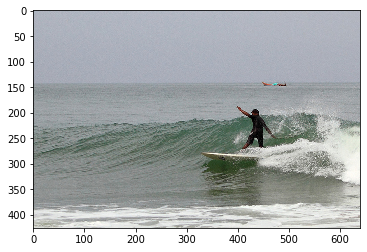

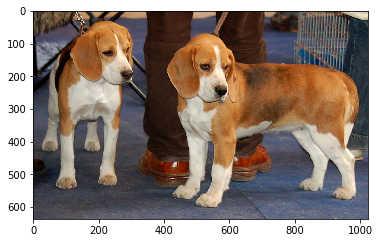

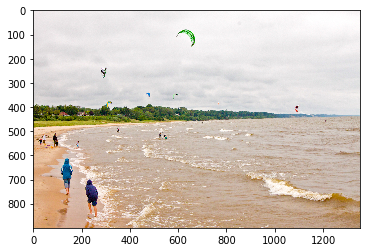

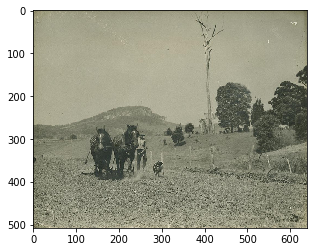

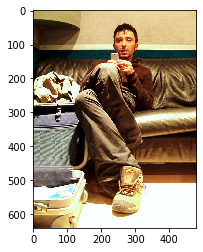

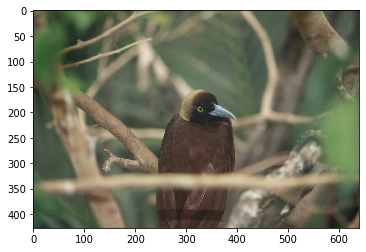

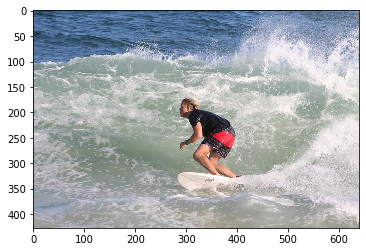

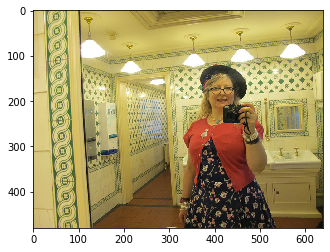

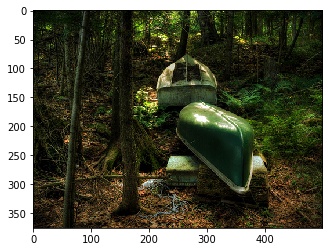

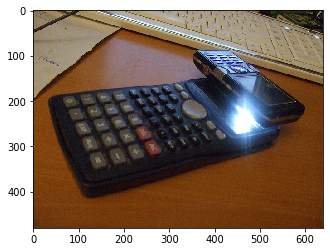

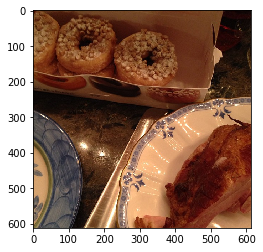

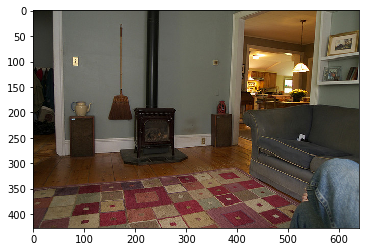

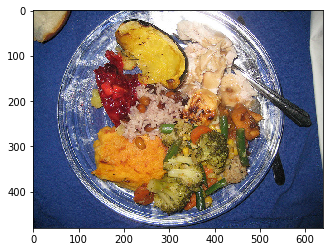

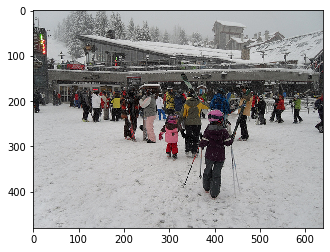

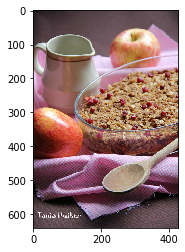

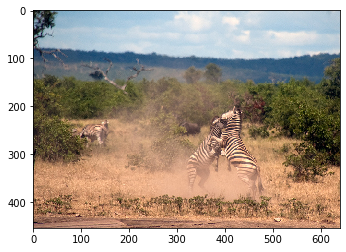

Execute TRT engine...
Start to run TRT inference...
TRT inference done.
TensorRT inference time: 13 ms
Done.


In [15]:
import time

TEST_IMAGE_PATH = os.getcwd() + "/test_samples"
TEST_IMAGES = [TEST_IMAGE_PATH+"/%06i.jpg"%(i+0) for i in range(TRT_MAX_BATCH_SIZE)]
#for idx, image_path in enumerate(TEST_IMAGES):
#        print(idx, image_path)
print("Load input images...")
images = load_batch_from_path(TEST_IMAGES)


# Copy it into appropriate place into memory
# (self.inputs was returned earlier by allocate_buffers())
np.copyto(inputs[0].host, images.ravel())

print("Execute TRT engine...")
# When infering on single image, we measure inference
# time to output it to the user
inference_start_time = time.time()

# Fetch output from the model
[detection_out, keep_count_out] = do_inference( \
            context, bindings, inputs, outputs, stream, TRT_MAX_BATCH_SIZE)

# Output inference time
print("TensorRT inference time: {} ms".format( \
            int(round((time.time() - inference_start_time) * 1000))))

print("Done.")
#print(detection_out)
#print(keep_count_out)

### 4.3 Check Output <a class="anchor" id="head-4-3"></a>

In [16]:
import utils.boxes as boxes_utils # Drawing bounding boxes
import utils.coco as coco_utils # COCO helper

# Layout of TensorRT network output metadata
TRT_PREDICTION_LAYOUT = {
    "image_id": 0,
    "label": 1,
    "confidence": 2,
    "xmin": 3,
    "ymin": 4,
    "xmax": 5,
    "ymax": 6
}

# Confidence threshold for drawing bounding box
VISUALIZATION_THRESHOLD = 0.5
# COCO label list
COCO_LABELS = coco_utils.COCO_CLASSES_LIST
# Random RGB colors for each class (useful for drawing bounding boxes)
COCO_COLORS = coco_utils.COCO_COLORS


def fetch_prediction_field(field_name, detection_out, pred_start_idx):
    """Fetches prediction field from prediction byte array.

    After TensorRT inference, prediction data is saved in
    byte array and returned by object detection network.
    This byte array contains several pieces of data about
    prediction - we call one such piece a prediction field.
    The prediction fields layout is described in TRT_PREDICTION_LAYOUT.

    This function, given prediction byte array returned by network,
    staring index of given prediction and field name of interest,
    returns prediction field data corresponding to given arguments.

    Args:
        field_name (str): field of interest, one of keys of TRT_PREDICTION_LAYOUT
        detection_out (array): object detection network output
        pred_start_idx (int): start index of prediction of interest in detection_out

    Returns:
        Prediction field corresponding to given data.
    """
    return detection_out[pred_start_idx + TRT_PREDICTION_LAYOUT[field_name]]


def analyze_prediction(detection_out, pred_start_idx, img_pil):
    image_id = int(fetch_prediction_field("image_id", detection_out, pred_start_idx))
    label = int(fetch_prediction_field("label", detection_out, pred_start_idx))
    confidence = fetch_prediction_field("confidence", detection_out, pred_start_idx)
    xmin = fetch_prediction_field("xmin", detection_out, pred_start_idx)
    ymin = fetch_prediction_field("ymin", detection_out, pred_start_idx)
    xmax = fetch_prediction_field("xmax", detection_out, pred_start_idx)
    ymax = fetch_prediction_field("ymax", detection_out, pred_start_idx)
    #print("confidence : %f / id:%i"%(confidence,image_id))
    if confidence > VISUALIZATION_THRESHOLD:
        class_name = COCO_LABELS[label]
        confidence_percentage = "{0:.0%}".format(confidence)
        print("Detected {} with confidence {}".format(
            class_name, confidence_percentage))
        boxes_utils.draw_bounding_boxes_on_image(
            img_pil, np.array([[ymin, xmin, ymax, xmax]]),
            display_str_list=["{}: {}".format(
                class_name, confidence_percentage)],
            color=COCO_COLORS[label]
        )

Detected person with confidence 71%


Detected dog with confidence 99%
Detected dog with confidence 93%
Detected person with confidence 50%


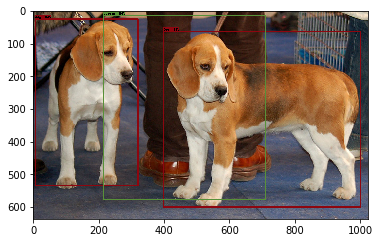

Detected kite with confidence 96%
Detected person with confidence 93%
Detected kite with confidence 90%
Detected person with confidence 90%
Detected kite with confidence 89%
Detected kite with confidence 84%
Detected person with confidence 78%
Detected kite with confidence 72%
Detected person with confidence 71%
Detected person with confidence 69%
Detected kite with confidence 68%
Detected kite with confidence 67%
Detected person with confidence 67%
Detected person with confidence 57%
Detected person with confidence 53%


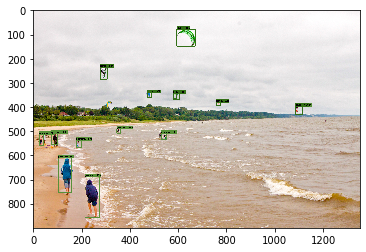

Detected person with confidence 57%
Detected person with confidence 55%


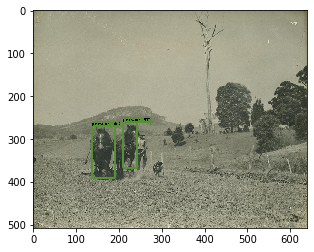

Detected person with confidence 99%
Detected couch with confidence 73%
Detected suitcase with confidence 53%


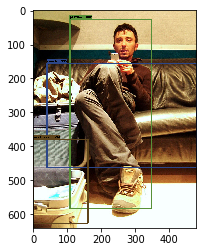

Detected bird with confidence 98%


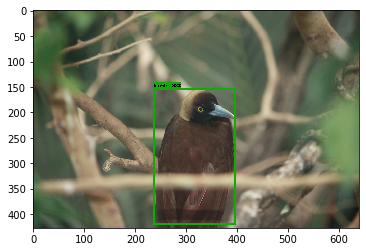

Detected person with confidence 100%


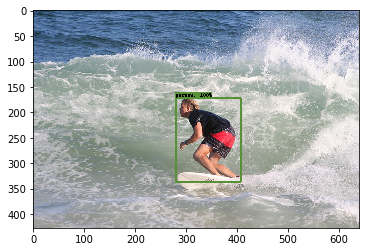

Detected person with confidence 97%


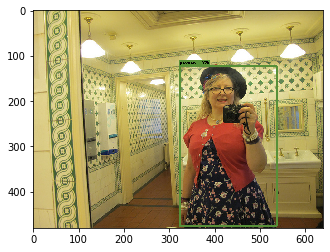

Detected boat with confidence 97%


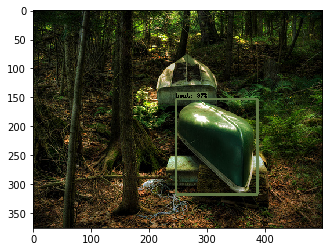

Detected cell phone with confidence 100%
Detected keyboard with confidence 71%


Detected donut with confidence 99%
Detected donut with confidence 98%
Detected dining table with confidence 96%
Detected cake with confidence 80%


Detected couch with confidence 97%
Detected book with confidence 59%
Detected book with confidence 52%
Detected person with confidence 50%


Detected fork with confidence 94%
Detected dining table with confidence 77%


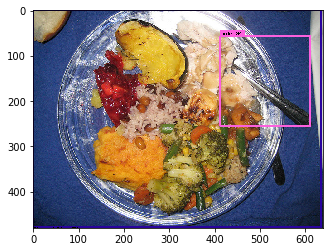

Detected person with confidence 85%
Detected person with confidence 84%
Detected person with confidence 84%
Detected person with confidence 83%
Detected person with confidence 83%
Detected person with confidence 76%
Detected person with confidence 72%
Detected person with confidence 72%
Detected person with confidence 70%
Detected person with confidence 69%
Detected person with confidence 64%
Detected person with confidence 55%
Detected person with confidence 54%
Detected person with confidence 52%
Detected person with confidence 51%
Detected person with confidence 51%


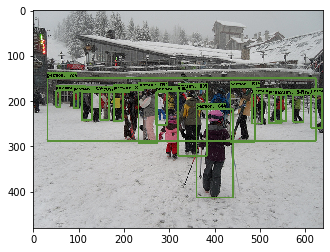

Detected spoon with confidence 97%
Detected apple with confidence 96%
Detected bowl with confidence 96%
Detected cup with confidence 93%
Detected apple with confidence 93%
Detected dining table with confidence 76%


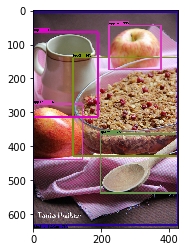

Detected zebra with confidence 99%


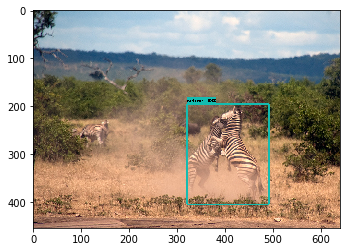

In [17]:
# Overlay the bounding boxes on the image
# let analyze_prediction() draw them based on model output
for idx in range(TRT_MAX_BATCH_SIZE):
    img_pil = Image.open(TEST_IMAGES[idx])
    prediction_fields = len(TRT_PREDICTION_LAYOUT)
    for det in range(int(keep_count_out[0])):
        analyze_prediction(detection_out, det * prediction_fields + idx * prediction_fields * keep_count_out[0], img_pil)
    final_img = np.asarray(img_pil)
    plt.imshow(final_img)
    plt.show()


## 5. (Additional) TensorRT Inference on Deepstream pipeline <a class="anchor" id="head-5"></a>

![TensorRT on Deepstream](images/tensorrt_ondeepstream.png)

Done.